Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
from sklearn.feature_selection import SelectKBest

%matplotlib inline

Загружаем данные из CSV. Данные преобразовываются в CSV с помощью утилиты `make_dataset`, которая собирается вместе с `SoFCheck`'ом

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data

,winner,game_id,board_total,board_left,psq.cost.0,psq.cost.1,psq.cost.2,psq.cost.3,psq.cost.4,psq.cost.5,...,psq.king_end.63,queen_near_to_king,two_bishops,pawn_isolated,pawn_double,pawn_passed,pawn_candidate,pawn_open,pawn_protected,pawn_backward
0,1.0,64808,144,84,256,0,0,-256,256,0,...,-96,-512,0,512,0,0,0,256,256,0
1,0.0,88564,113,79,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.5,73859,141,52,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-256,0
3,0.5,1690,142,60,-256,0,0,0,0,0,...,0,0,0,0,0,-256,0,0,0,0
4,0.0,15591,121,42,0,0,0,0,0,0,...,0,0,0,-512,0,-256,0,256,256,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,0.0,27657,143,112,256,0,0,0,0,0,...,0,0,0,256,0,0,256,0,0,0
2999996,1.0,11347,166,152,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-512,0
2999997,1.0,40768,146,84,-512,0,0,256,0,0,...,0,0,0,0,0,-256,0,-256,0,0
2999998,1.0,40032,118,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dv = data.values

Делим выборку на обучающую и тестовую. Деление осуществляем по `game_id`, чтобы позиции из одной игры не оказались в разных выборках.

In [5]:
games = np.array([i+1 for i in range(data['game_id'].max())])

games_train, games_test = train_test_split(games, test_size=0.1, shuffle=True)

In [6]:
train_set = set(games_train)
test_set = set(games_test)

is_train = np.vectorize(lambda x: x in train_set)
is_test = np.vectorize(lambda x: x in test_set)

dv_train = dv[is_train(dv[:,1])]
dv_test = dv[is_test(dv[:,1])]

In [7]:
del data
del dv

In [8]:
X = dv_train[:,4:]
y = dv_train[:,0]
w = dv_train[:,3]

X_test = dv_test[:,4:]
y_test = dv_test[:,0]
w_test = dv_test[:,3]

del dv_train
del dv_test

Ищем разброс значений (т.е. $\max - \min$) каждого из признаков. Это нам понадобится в дальнейшем для масштабирования:

In [9]:
std = np.max(X, axis=0) - np.min(X, axis=0)
std = np.maximum(np.min(std[std > 1e-9]), std)  # чтобы не допустить деления на ноль в дальнейшем
std

array([3584.,  256., 1024., 1024., 1280., 1536.,  256.,  256.,  256.,
        256.,  256.,  256.,  256.,  256.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,  256.,
        256.,  256.,  256.,  256.,  256.,  256.,  256.,  299.,  341.,
        299.,  288.,  288.,  267.,  256.,  277.,  331.,  298.,  277.,
        288.,  341.,  330.,  320.,  288.,  288.,  362.,  309.,  320.,
        330.,  277.,  352.,  342.,  352.,  342.,  406.,  298.,  341.,
        373.,  384.,  331.,  384.,  395.,  427.,  427.,  426.,  416.,
        426.,  426.,  437.,  501.,  470.,  490.,  480.,  470.,  470.,
        501.,  491.,  512.,  512.,  512.,  512.,  512.,  512.,  512.,
        512.,  512.,

Масштабируем признаки:

In [10]:
X /= std
X_test /= std

Создаем нашу модель. Здесь используется модель, описанная [на Хабре](https://habr.com/ru/post/305604/), только мы не пишем градиентный спуск руками, а используем силу PyTorch

In [11]:
model = nn.Sequential()
model.add_module('linear', nn.Linear(X.shape[1], 1, bias=False))
model.add_module('sigmoid', nn.Sigmoid())

In [12]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)

Определяем функцию потерь:

In [13]:
def get_loss(model, X, y, w, C=0.0):
    w = np.exp(-w / 32.)
    y_pred = model(X)[:, 0]
    assert y_pred.dim() == 1
    loss = torch.sum(w * ((y - y_pred) ** 2)) / torch.sum(w)
    loss += C * torch.norm(model.linear.weight, 2)
    return loss

Обучаем, пока не сойдется функция потерь. Для этого может быть полезно запустить ячейку несколько раз. А может быть, ее стоит остановить раньше.

In [14]:
C = 4e-6

history = []

for i in range(6000):
    # собираем батч
    indices = np.random.randint(0, X.shape[0], 8000)
    X_batch = torch.tensor(X[indices], dtype=torch.float32)
    y_batch = torch.tensor(y[indices], dtype=torch.float32)
    w_batch = torch.tensor(w[indices], dtype=torch.float32)
    
    # считаем функцию потерь
    loss = get_loss(model, X_batch, y_batch, w_batch, C=C)

    loss.backward()
    
    # надо раскомментить, если хочется менять только короля
    # model.linear.weight.grad[0, 0:6+64] = 0
    # model.linear.weight.grad[0, 6+64:6+384] = 0
    # model.linear.weight.grad[0, 6+448:] = 0
    
    # оптимизируем
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())

    # выводим результаты
    if i % 100 == 0:
        test_loss = get_loss(model,
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32),
            torch.tensor(w_test, dtype=torch.float32),
            C=0.0).detach().numpy().sum()
        train_loss = np.mean(history[-40:])
        print(f"step #{i}, train_loss = {train_loss:.4f}, test_loss = {test_loss:.4f}")

step #0, train_loss = 0.1675, test_loss = 0.1616
step #100, train_loss = 0.0936, test_loss = 0.0883
step #200, train_loss = 0.0763, test_loss = 0.0746
step #300, train_loss = 0.0693, test_loss = 0.0683
step #400, train_loss = 0.0652, test_loss = 0.0647
step #500, train_loss = 0.0631, test_loss = 0.0625
step #600, train_loss = 0.0618, test_loss = 0.0609
step #700, train_loss = 0.0606, test_loss = 0.0598
step #800, train_loss = 0.0600, test_loss = 0.0591
step #900, train_loss = 0.0588, test_loss = 0.0584
step #1000, train_loss = 0.0586, test_loss = 0.0579
step #1100, train_loss = 0.0578, test_loss = 0.0575
step #1200, train_loss = 0.0579, test_loss = 0.0572
step #1300, train_loss = 0.0576, test_loss = 0.0569
step #1400, train_loss = 0.0574, test_loss = 0.0567
step #1500, train_loss = 0.0566, test_loss = 0.0565
step #1600, train_loss = 0.0571, test_loss = 0.0563
step #1700, train_loss = 0.0568, test_loss = 0.0562
step #1800, train_loss = 0.0566, test_loss = 0.0560
step #1900, train_loss =

Смотрим на итоговое значение функции потерь на тестовом датасете:

In [15]:
test_loss = get_loss(model,
                     torch.tensor(X_test, dtype=torch.float32),
                     torch.tensor(y_test, dtype=torch.float32),
                     torch.tensor(w_test, dtype=torch.float32)).detach().numpy().sum()
test_loss

0.055192202

Ради интереса посмотрим на вероятности, которые предсказывает модель для каких-то $20$ соседних примеров тестовой выборки:

In [16]:
res = model(torch.tensor(X_test, dtype=torch.float32))[:, 0]

print(res[450:470], y_test[450:470])

tensor([0.5447, 0.0734, 0.4709, 0.8346, 0.4084, 0.5157, 0.9600, 0.6695, 0.4917,
        0.9575, 0.6192, 0.6639, 0.0975, 0.9505, 0.7823, 0.5271, 0.5912, 0.1593,
        0.4028, 0.6762], grad_fn=<SliceBackward>) [0.  0.  0.  0.5 0.5 0.5 1.  1.  0.5 1.  1.  0.5 0.  1.  0.  0.  0.  0.
 0.5 1. ]


Теперь было бы неплохо преобразовать веса модели в коэффициенты, которые мы будем использовать в шахматной программе. Для этого нормируем таблицы фигура-поле так, чтобы медианное значение занулилось. Затем умножим все веса на одно и то же число так, чтобы стоимость пешки была равна `100` (т. е. одной пешке)

In [17]:
ws = (model.linear.weight[0]).detach().numpy() / std
for p in [0, 2, 3, 4, 5]:
    left = 6 + 64 * p
    right = 6 + 64 * (p + 1)
    if p == 0:
        # верхний и нижний ряд у пешки не используется, не обращаем на него внимание
        left += 8
        right -= 8
    m = np.median(ws[left:right])
    ws[left:right] -= m
    ws[p] += m

ww = (ws / ws[0] * 100).astype(np.int32)
print(ww)

[ 100    0  325  350  556 1028    0    0    0    0    0    0    0    0
  161  189  190  154  150  145  172  137   93   88   68   62   42   64
   68   78   26   23   -7   -3   18    5    1   10   -6   -7  -12   -8
  -16    0  -12  -12   -7  -13  -17  -18  -13  -11   -5  -11   -6   -3
  -11  -47  -17    0    8  -16    0    0    0    0    0    0    0    0
  398  408  190  282  246  156  140 -276  140  -72   20 -354   -5  -46
  -61 -276 -115  -98 -319 -332 -307  -49 -131 -219 -143  -44 -144 -200
  -78 -119 -125 -183  -11   50  104   27  -12   27   -1 -131    6   33
   35   69   15   41  -11  -39    3  -32  -18   -1   -2    0   47   77
 -161   40   30  -98    8  -88   76   47  -70  -19    4    3    0  -46
  -22  -84  -37    0   10   44   37   35    8  -69   -3   13   37   28
   49   41   45    5  -14   -8   41   56   49   51   47   19  -44   -4
   16    9   30   30   27   22  -71  -24   -3   16   14   14   10  -14
  -60  -16   -9   -6   -6    1  -24  -12 -130  -63  -34  -36  -33  -26
   -7 

Эти веса уже можно скопировать, вставить в утилиту `apply_weigths` и использовать в `SoFCheck`'е.

Далее визуализируем полученные веса:

In [18]:
def display_mat(mat):
    plt.matshow(mat)
    for (x, y), value in np.ndenumerate(mat):
        plt.text(y, x, f"{value}", va="center", ha="center")

Стоимости фигур:

In [19]:
ww[:6]

array([ 100,    0,  325,  350,  556, 1028], dtype=int32)

Таблицы фигура-поле для пешки:

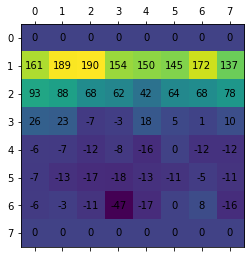

In [20]:
display_mat(ww[6:6+64].reshape(8, 8))

Таблицы фигура-поле для короля в миттельшпиле:

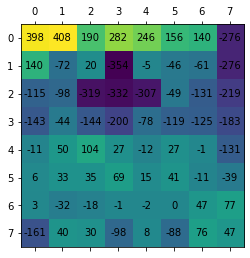

In [21]:
display_mat(ww[6+64:6+128].reshape(8, 8))

Таблицы фигура-поле для коня:

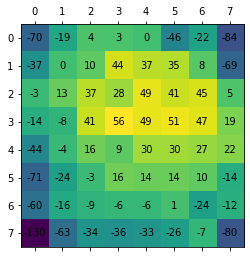

In [22]:
display_mat(ww[6+128:6+192].reshape(8, 8))

Таблицы фигура-поле для слона:

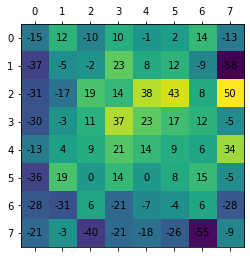

In [23]:
display_mat(ww[6+192:6+256].reshape(8, 8))

Таблицы фигура-поле для ладьи:

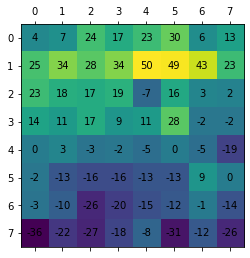

In [24]:
display_mat(ww[6+256:6+320].reshape(8, 8))

Таблицы фигура-поле для ферзя:

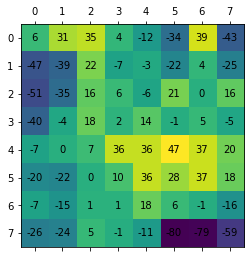

In [25]:
display_mat(ww[6+320:6+384].reshape(8, 8))

Таблицы фигура-поле для короля в эндшпиле:

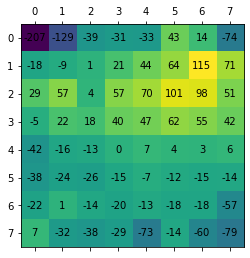

In [26]:
display_mat(ww[6+384:6+448].reshape(8, 8))

Стоимость ферзя, близкого к вражескому королю, и стоимость двух слонов:

In [27]:
ww[454], ww[455]

(55, 37)

Стоимость пешек: изолированная, двойная, проходная:

In [28]:
ww[456], ww[457], ww[458]

(-9, -8, 31)